# Generalised Bernoulli map with various number formats

Revisiting BM Boghosian, PV Coveney, and H Wang. *A new pathology in the Simulation of Chaotic Dynamical Systems on Digital Computers*, **Adv. Theory Simul.** 2019, 2, 1900125, DOI: 10.1002/adts.201900125

### 0. Load packages

In [1]:
using PyPlot, FileIO, JLD2
using StochasticRounding, SoftPosit, LogFixPoint16s
using StatsBase, LinearAlgebra, Statistics
LogFixPoint16s.set_nfrac(10)   # use the 16-bit logfix format similar to Float16

┌ Warning: LogFixPoint16 was changed to 5 integer and 10 fraction bits.
└ @ LogFixPoint16s /Users/milan/.julia/packages/LogFixPoint16s/TGYbV/src/change_format.jl:25


### 1. Functions
Define the generalised Bernoulli map

$\quad x_{j+1} = f_\beta(x_j) = \beta x_j \mod 1$

with $\beta > 1$.

In [2]:
function bernoulli_map(x::T,β::T,N::Int) where T
    oone = one(T)                  # 1 in format T
    xout = Array{T,1}(undef,N+1)   # preallocate
    xout[1] = x                    # store initial condition
    for i in 2:N+1
        x = β*x
        while x >= oone            # x mod 1
            x = x - oone
        end
        xout[i] = x                # store iteration
    end
    return xout
end

bernoulli_map (generic function with 1 method)

And the Hofbauer invariant measure (Eq. 1 in Boghosian, Coveney and Wang, 2019)

$\quad h_\beta(x) = C\sum_{j=0}^\infty \beta^{-j} \theta(1_j - x)$

with $C$ a normalization constant, $\theta$ the Heaviside function and $1_j = f_\beta^j(1)$.

In [3]:
# Hofbauer invariant measure h with C=1
heaviside(x::AbstractFloat) = ifelse(x < 0, zero(x), ifelse(x > 0, one(x), oftype(x,0.5)))
h(x,β,N=100) = heaviside(1-x) + [β^-j for j in 1:N]'*heaviside.(bernoulli_map(1e0,β,N)[2:end] .- x)

h (generic function with 2 methods)

### 2. Some iterations of the Bernoulli map with β=2

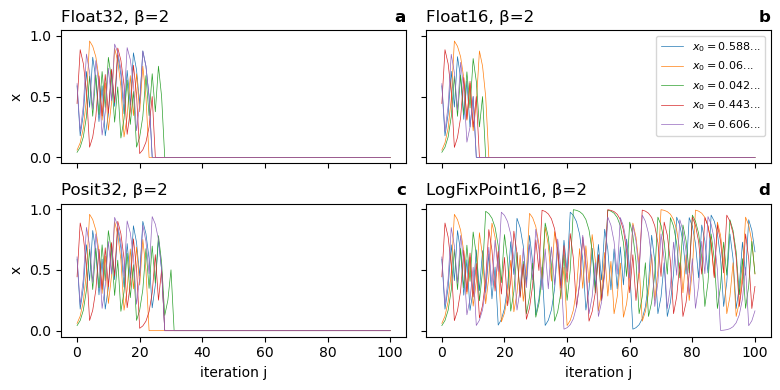

In [4]:
# pick N random start values [0,1)
Nens = 5    # ensemble N
Ns = 100    # iteration N
x0 = rand(Nens)
β = 2

fig,axs = subplots(2,2,sharex=true,sharey=true,figsize=(8,4))

for i in 1:Nens
    axs[1,1].plot(bernoulli_map(Float32(x0[i]),Float32(β),Ns),lw=.5)
    axs[1,2].plot(bernoulli_map(Float16(x0[i]),Float16(β),Ns),lw=.5,label=L"x_0 = "*"$(round(x0[i],digits=3))...")
    axs[2,1].plot(bernoulli_map(Posit32(x0[i]),Posit32(β),Ns),lw=.5)
    axs[2,2].plot(bernoulli_map(LogFixPoint16(x0[i]),LogFixPoint16(β),Ns),lw=.5)
end

axs[1,1].set_title("Float32, β=$β",loc="left")
axs[1,2].set_title("Float16, β=$β",loc="left")
axs[2,1].set_title("Posit32, β=$β",loc="left")
axs[2,2].set_title("LogFixPoint16, β=$β",loc="left")

for (iabc,abc) in enumerate(["a","c","b","d"])
    axs[iabc].set_title(abc,loc="right",fontweight="bold")
end

axs[1,1].set_ylabel("x")
axs[2,1].set_ylabel("x")
axs[2,1].set_xlabel("iteration j")
axs[2,2].set_xlabel("iteration j")

axs[1,2].legend(fontsize=8)

tight_layout()
# savefig("../plots/beta2.png")

**Fig. 1**: The generalised Bernoulli map $f_\beta$ for $\beta=2$ with different number formats. (a) Float32, (b) Float16, (c) Posit32 and (d) LogFixPoint16. The Bernoulli map $f_2$ does not introduce arithmetic rounding errors in (a-c), such that stochastic rounding has no impact. The logfix subtraction in $f_2$ introduces rounding errors in (d) that prevent the stalling at 0 in (a-c).

### 3. Numerical representation of the invariant measures

In [5]:
# Calculate histograms
Nens = 1000              # start from Nens random initial conditions
Nsteps = 10000           # integrate for Nsteps time steps
Nspinup = 100            # discard Nspinsup time steps

formats = [Float64,Float32,Posit32,Float32sr,Float16,LogFixPoint16]   # simulate with formats
βs = [3/2,5/4,4/3,6/5]                                                # each for different β
Nformats = length(formats)
Nβs = length(βs)

# bins
bin_edges = collect(0:2.5e-2:1)
nbins = length(bin_edges)-1

# preallocate all histograms
Histos = fill(0.0,Nformats,Nβs,nbins)

for (iformat,format) in enumerate(formats)
    for (iβ,β) in enumerate(βs)
        X = fill(0.0,Nens,Nsteps)
        for iens in 1:Nens
            X[iens,:] = bernoulli_map(format(rand()),format(β),Nsteps+Nspinup)[Nspinup+2:end]
        end
        H = fit(Histogram,vec(X),bin_edges).weights
        Histos[iformat,iβ,:] = H / sum(H*(bin_edges[2]-bin_edges[1]))
    end
end     

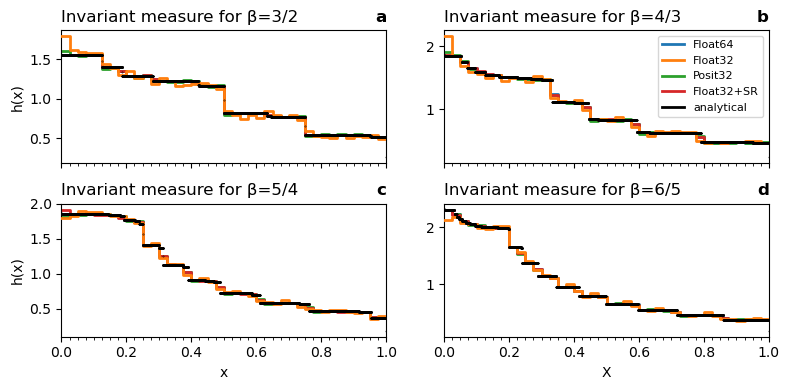

In [6]:
# PLOT
fig,axs = subplots(2,2,sharex=true,figsize=(8,4))

for (iax,ax) in enumerate(axs)
    H = Histos[1,iax,:]
    ax.plot(bin_edges,vcat(H[1],H),ds="steps-pre",lw=2,label="Float64")
    
    H = Histos[2,iax,:]
    ax.plot(bin_edges,vcat(H[1],H),ds="steps-pre",lw=2,label="Float32",zorder=9)
    
    H = Histos[3,iax,:]
    ax.plot(bin_edges,vcat(H[1],H),ds="steps-pre",lw=2,label="Posit32")
    
    H = Histos[4,iax,:]
    ax.plot(bin_edges,vcat(H[1],H),ds="steps-pre",lw=2,label="Float32+SR")
end


# Add analytical invariant measures from Hofbauer
x = collect(0:1e-4:1)
for (iβ,β) in enumerate(βs)
    hx = h.(x,β)
    axs[iβ].scatter(x,hx/sum(hx*(x[2]-x[1])),0.1,color="k",zorder=10)
    # only for legend (plot outside xlim,ylim)
    axs[iβ].plot(-x,hx/sum(hx*(x[2]-x[1])),"k",lw=2,label="analytical")
end

for (iβ,β) in enumerate(["3/2","5/4","4/3","6/5"])
    axs[iβ].set_title("Invariant measure for β=$β",loc="left")
end

for (iabc,abc) in enumerate(["a","c","b","d"])
    axs[iabc].set_title(abc,loc="right",fontweight="bold")
end

axs[1,2].legend(loc=1,fontsize=8)

axs[1,1].set_ylabel("h(x)")
axs[2,1].set_ylabel("h(x)")
axs[2,1].set_xlabel("x")
axs[2,2].set_xlabel("X")
axs[1,1].set_xlim(0,1)
axs[1,1].set_xticks(bin_edges,minor=true)

tight_layout()
# savefig("../plots/inv_measures.png")

**Fig. 2**: The invariant measures of the generalised Bernoulli map for β = (a) $\frac{3}{2}$, (b) $\frac{4}{3}$, (c) $\frac{5}{4}$ and (d) $\frac{6}{5}$ calculated with different number formats and rounding modes: 64 and 32-bit floating-point numbers (Float64,Float32), 32-bit posits and Float32 with stochastic rounding. The invariant measures are obtained from long integrations of the Bernoulli map from many different initial conditions $x_0$ in [0,1). Histograms of $x$ with bin width 0.025 and the analytical invariant measures are normalised.

### 4. Error of the invariant measures

In [7]:
# Sample analytical invariant measure at bins
hxs = fill(0.0,Nβs,nbins)
x = collect(0:1e-6:1)

for (iβ,β) in enumerate(βs)
    H = [sum(h.(x[(x .>= bin_edges[i]) .& (x .< bin_edges[i+1])],β)) for i in 1:nbins]
    hxs[iβ,:] = H / sum(H*(bin_edges[2]-bin_edges[1]))
end

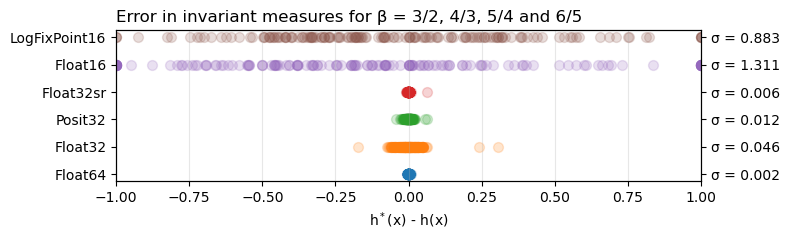

In [8]:
fig,ax = subplots(1,1,figsize=(8,2.5))

ax2 = ax.twinx()

xe1,xe2 = -1,1
for i in 1:Nformats
    errors = vec(Histos[i,:,:]-hxs[:,:])
    errors = max.(errors,xe1)    # clip values to points at the axis boundaries
    errors = min.(errors,xe2)
    ax.scatter(errors,i*ones(nbins*Nβs),50,alpha=.2)
end

ax.set_yticks(1:Nformats)
ax.set_yticklabels(string.(formats))
ax.grid(axis="x",alpha=.3)
ax.set_xlim(xe1,xe2)

ax2.set_yticks(1:Nformats)
ax2.set_ylim(ax.get_ylim())
stds = [std(vec(Histos[i,:,:]-hxs[:,:])) for i in 1:Nformats] 
ax2.set_yticklabels(["σ = $(round(s,digits=3))" for s in stds])

ax.set_title("Error in invariant measures for β = 3/2, 4/3, 5/4 and 6/5",loc="left")
ax.set_xlabel("h"*L"^*"*"(x) - h(x)")

tight_layout()
# savefig("../plots/error_invariant.png")

**Fig. 3:** Error in the invariant measures for the Bernoulli map. The invariant measures $h^*(x)$ simulated with different number formats are quantified from the histograms in Fig. 2. The errors are calculated with respect to the analytical invariant measures $h(x)$. The standard deviations of the error distributions are denoted with $\sigma$.

### 5. Invariant measure bifurcation figure

In [ ]:
# ANALYTICAL
x2 = collect(0:5e-3:1)
βs2 = collect(1:1e-3:2)

# preallocate
nx,nβs = length(x2),length(βs2)
hxβ0 = fill(0.0,nx,nβs)
hxβ = fill(0.0,nbins,nβs)

# Invariant measures directly (for correct normalisation only)
for (iβ,β) in enumerate(βs2)
    hx = h.(x2,β)
    hxβ0[:,iβ] = hx/sum(hx*(x2[2]-x2[1]))
end

# get the analytical distribution from Hofbauer's h(x)
# then sample & calculate a histogram as with the numerical simulations
for (iβ,β) in enumerate(βs2) 
    aw = aweights(h.(x2,β))
    xsample = sample(x2,aw,Nsteps*Nens)
    
    H = fit(Histogram,xsample,bin_edges).weights
    hxβ[:,iβ] = H / sum(H*(bin_edges[2]-bin_edges[1]))
end

In [14]:
# preallocate all histograms
Nens = 1000               # start from Nens random initial conditions
Nsteps = 10000            # integrate for Nsteps time steps
Histos2 = fill(0.0,Nformats,nβs,nbins)

for (iformat,format) in enumerate(formats)
    for (iβ,β) in enumerate(βs2)
        X = fill(0.0,Nens,Nsteps)
        for iens in 1:Nens
            X[iens,:] = bernoulli_map(format(rand()),format(β),Nsteps+Nspinup)[Nspinup+2:end]
        end
        H = fit(Histogram,vec(X),bin_edges).weights
        Histos2[iformat,iβ,:] = H / sum(H*(bin_edges[2]-bin_edges[1]))
    end
end

In [9]:
# @save "histos2.jld2" Histos2 hxβ formats βs2 bin_edges
@load "histos2.jld2" Histos2 hxβ

2-element Array{Symbol,1}:
 :Histos2
 :hxβ

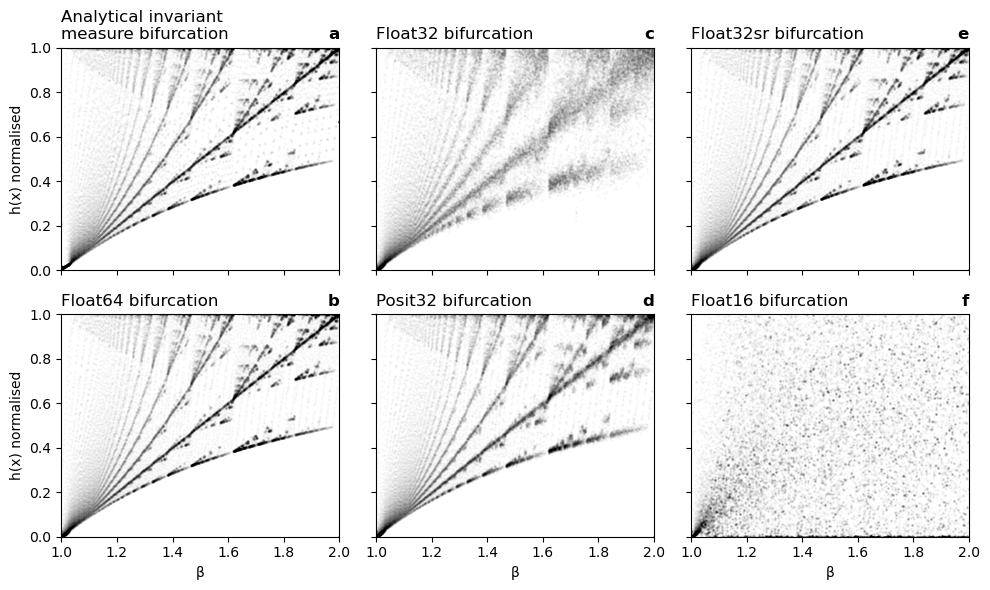

In [52]:
fig,axs = subplots(2,3,sharex=true,sharey=true,figsize=(10,6))

for (iβ,β) in enumerate(βs2)
    axs[1,1].scatter(β*ones(nbins),hxβ[:,iβ]/maximum(hxβ0[:,iβ]),1,color="k",alpha=0.02)
    for i in 2:length(axs)
        axs[i].scatter(β*ones(nbins),Histos2[i-1,iβ,:]/maximum(hxβ0[:,iβ]),1,color="k",alpha=0.02)
    end
end

axs[2,1].set_xlabel("β")
axs[2,2].set_xlabel("β")
axs[2,3].set_xlabel("β")
axs[1,1].set_ylabel("h(x) normalised")
axs[2,1].set_ylabel("h(x) normalised")
axs[1,1].set_xlim(extrema(βs2))
axs[1,1].set_ylim(0,1)

axs[1,1].set_title("Analytical invariant\nmeasure bifurcation",loc="left")
axs[1,1].set_title("a",loc="right",fontweight="bold")
for i in 2:length(axs)
    axs[i].set_title("$(string(formats[i-1])) bifurcation",loc="left")
    axs[i].set_title(string(Char(96+i)),loc="right",fontweight="bold")
end
    
tight_layout()
# savefig("../plots/bifurcation.png")

**Fig. 4** Bifurction diagram of the invariant measure $h(x)$ analytically and as simulated with various number formats. (a) Analytical invariant measure's bifurcation from Hofbauer's $h(x)$, (b-f) Bifurcation obtained from the histograms of $x$ simulated with various number formats: (b) Float64, (c) Float32, (d) Posit32, (e) Float32 + stochastic rounding, (f) Float16. Normlisation is applied with max($h_\beta(x)$).

## 6. Attractor 

In [58]:
x2 = collect(0:1e-3:1)
βs2 = collect(1:1e-3:2)
nx,nβs = length(x2),length(βs2)
nsample = 500

# create a matrix of βs
ββ = fill(0.0,nsample,nβs)
for i in 1:nβs
    ββ[:,i] .= βs2[i]
end

# sample analytical & numerical x
nens = 20
xβsample = fill(0.0,nsample,nβs)
xβFsample = fill(0.0,Nformats,nsample,nβs)

for (iβ,β) in enumerate(βs2) 
    # analytical
    aw = aweights(h.(x2,β))
    xsample = sample(x2,aw,nsample)
    xβsample[:,iβ] = xsample
    
    for (iformat,format) in enumerate(formats)
        X = fill(zero(format),nens,nsample÷nens)
        for i in 1:nens
            X[i,:] = bernoulli_map(format(rand()),format(β),nsample÷nens+500)[502:end]
        end
        xβFsample[iformat,:,iβ] = vec(X)
    end
end

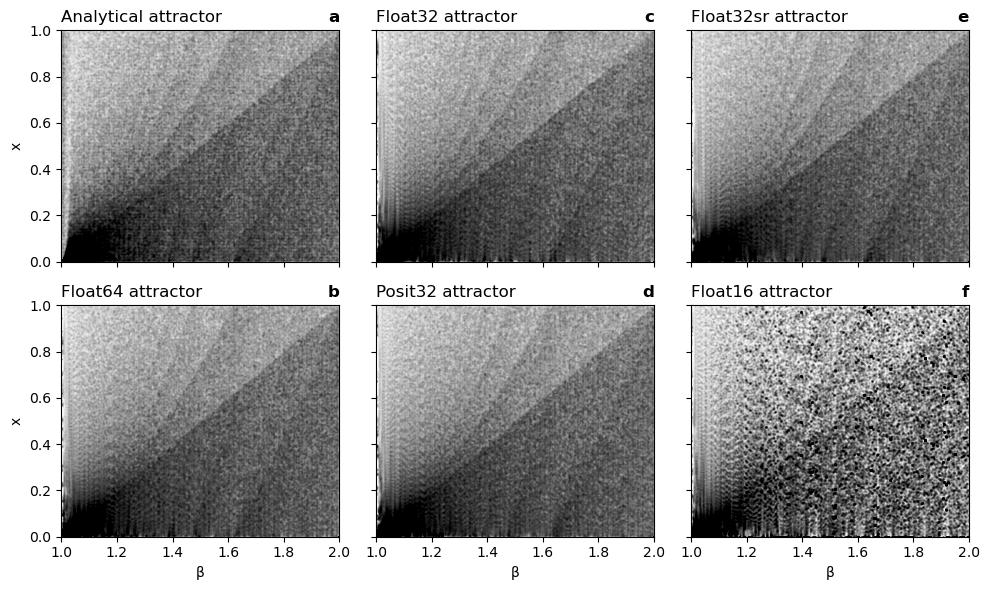

In [59]:
fig,axs = subplots(2,3,sharex=true,sharey=true,figsize=(10,6))

axs[1].scatter(ββ,xβsample,1,color="k",alpha=0.01)

for i in 1:5
    axs[i+1].scatter(ββ,xβFsample[i,:,:],1,color="k",alpha=0.01)
end

axs[2,1].set_xlabel("β")
axs[2,2].set_xlabel("β")
axs[2,3].set_xlabel("β")
axs[1,1].set_ylabel("x")
axs[2,1].set_ylabel("x")
axs[1,1].set_xlim(extrema(βs2))
axs[1,1].set_ylim(0,1)

axs[1,1].set_title("Analytical attractor",loc="left")
axs[1,1].set_title("a",loc="right",fontweight="bold")
for i in 2:length(axs)
    axs[i].set_title("$(string(formats[i-1])) attractor",loc="left")
    axs[i].set_title(string(Char(96+i)),loc="right",fontweight="bold")
end
    
tight_layout()
# savefig("../plots/attractor.png")

**Fig. 5** Analytical attractor and as simulated with various number formats. (a) Analytical attractor sampled from Hofbauer's $h(x)$, (b-f) attractors obtained from simulation of the generalised Bernoulli map with various number formats: (b) Float64, (c) Float32, (d) Posit32, (e) Float32 + stochastic rounding, (f) Float16.